In [1]:
cd /Users/leayamashiro/AliCPT/ali_LY_git

/Users/leayamashiro/AliCPT/ali_LY_git


In [2]:
import numpy as np
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False
import matplotlib.pyplot as plt
import scipy

from scipy.signal import sawtooth, square, savgol_filter
import pandas as pd
import glob as gl
import os
import cmath

from scipy.signal import sawtooth, square,find_peaks
from scipy import spatial
# import lambdafit as lf
from scipy.interpolate import CubicSpline,interp1d
import h5py

from tqdm import tqdm as tqdm_terminal
from tqdm.notebook import trange, tqdm_notebook
from scipy.signal.windows import hann

from scipy.fft import fft, ifft, fftfreq
from copy import deepcopy
from scipy.interpolate import CubicSpline, interp1d
from scipy.optimize import curve_fit

import ali_offline_demod as dmd

In [3]:
# FUNCTION JUST TO READ OUT FILE AND CHUNK EACH CHANNEL BY THE SAME T, I, Q DATA AS SEPARATE DATAFRAMES

def read_chunk_channels(filename):# single_channel, time='all', t_start=0, t_stop=28000):
    file = h5py.File(filename, 'r')
    # make arrays 
    i = np.array(file['time_ordered_data']['adc_i'])
    i = np.delete(i, slice(0,22), 0)
    q = np.array(file['time_ordered_data']['adc_q'])
    q = np.delete(q, slice(0,22), 0)
    t = np.array(file['time_ordered_data']['timestamp'])
    
    #initialize channel data dictionary
    channel_dict = {}

    # create structured array [t, i, q] for each channel
    for channel in range(i.shape[0]):
        # then store each channel as dataframe
        freqs_frame = pd.DataFrame({'t':t, 
                                    'i': i[channel], 
                                    'q': q[channel]
                                    })
        # store channel n in the greater dictionary
        channel_dict[channel] = freqs_frame
    
    return channel_dict

In [4]:
# FUNCTION 2: 
    # read file 
    # chunk channels into their own dataframes 
    # isolate desired channel
    # returns channel chunk as dataframe (just no time/event index component)

def read_chunk_isolate_channel(filename, single_channel):
    file = h5py.File(filename, 'r')
    # make arrays 
    i = np.array(file['time_ordered_data']['adc_i'])
    i = np.delete(i, slice(0,22), 0)
    q = np.array(file['time_ordered_data']['adc_q'])
    q = np.delete(q, slice(0,22), 0)
    t = np.array(file['time_ordered_data']['timestamp'])
    
    #initialize channel data dictionary
    channel_dict = {}

    # create structured array [t, i, q] for each channel
    for channel in range(i.shape[0]):
        # then store each channel as dataframe
        freqs_frame = pd.DataFrame({'t':t, 
                                    'i': i[channel], 
                                    'q': q[channel]
                                    })
        # store channel n in the greater dictionary
        channel_dict[channel] = freqs_frame
    
    selected_channel = channel_dict.get(single_channel)
    if selected_channel is None: 
        raise ValueError(f"channel {single_channel} not found")

    selected_channel = selected_channel.rename_axis('Event')

    return selected_channel


In [5]:

# FUNCTION 3: 
    # read file 
    # chunk channels into their own dataframes 
    # isolate desired channel
    # isolate time chunk within isolated channel 
    # returns channel and time chunk as Dataframe

def read_chunk_isolate_channel_time(filename, single_channel, time='all', t_index_start=None, t_index_stop=None):
    file = h5py.File(filename, 'r')
    # make arrays 
    i = np.array(file['time_ordered_data']['adc_i'])
    i = np.delete(i, slice(0,22), 0)
    q = np.array(file['time_ordered_data']['adc_q'])
    q = np.delete(q, slice(0,22), 0)
    t = np.array(file['time_ordered_data']['timestamp'])
    
    #initialize channel data dictionary
    channel_dict = {}

    # create structured array [t, i, q] for each channel
    for channel in range(i.shape[0]):
        # then store each channel as dataframe
        freqs_frame = pd.DataFrame({'t':t, 
                                    'i': i[channel], 
                                    'q': q[channel]
                                    })
        # store channel n in the greater dictionary
        channel_dict[channel] = freqs_frame
    
    # get desired channel
    selected_channel = channel_dict.get(single_channel)
    if selected_channel is None: 
        raise ValueError(f"channel {single_channel} not found")
    selected_channel = selected_channel.rename_axis('Event')

    # getting desired time chunk range (all or specific)
    if time == 'all':
        chunked_channel_time = selected_channel
    elif time == 'some':
        if t_index_start is None or t_index_stop is None: 
            raise ValueError('provide slice boundaries for time = some')
        chunked_channel_time = selected_channel.iloc[t_index_start:t_index_stop]

    return chunked_channel_time




In [6]:
cd /Users/leayamashiro/AliCPT/alicpt_data/data_files/

/Users/leayamashiro/AliCPT/alicpt_data/data_files


In [14]:
# testing the read_chunk_isolate_channel function: 
testfile = 'ts_toneinit_fcenter_4250.0_20240506174818_t_20240506191017.hd5'

testing_channels = [0, 1, 10, 100, 300, 400]

for i in range(len(testing_channels)):
    print('Channel: ' + str(testing_channels[i]), 
          read_chunk_isolate_channel(filename = testfile, single_channel=testing_channels[i]))

Channel: 0                    t    i    q
Event                         
0       1.715048e+09  587 -961
1       1.715048e+09  535 -953
2       1.715048e+09  515 -949
3       1.715048e+09  487 -933
4       1.715048e+09  504 -910
...              ...  ...  ...
293283  1.715048e+09  574 -947
293284  1.715048e+09  582 -963
293285  1.715048e+09  537 -955
293286  1.715048e+09  564 -943
293287  1.715048e+09  534 -911

[293288 rows x 3 columns]
Channel: 1                    t     i     q
Event                           
0       1.715048e+09  2374 -1274
1       1.715048e+09  3048 -2202
2       1.715048e+09  3034 -2376
3       1.715048e+09  2468 -1470
4       1.715048e+09  1245 -1046
...              ...   ...   ...
293283  1.715048e+09   203 -1725
293284  1.715048e+09   609 -1395
293285  1.715048e+09  1595 -1066
293286  1.715048e+09  2737 -1603
293287  1.715048e+09  3039 -2432

[293288 rows x 3 columns]
Channel: 10                    t     i     q
Event                           
0       1.7150

In [108]:
testing_chunk_channel_time_100 = read_chunk_isolate_channel_time(filename=testfile, single_channel=100, time='some', t_index_start=10000, t_index_stop=20000)

In [111]:
testing_chunk_channel_time_100_2 = read_chunk_isolate_channel_time(filename=testfile, single_channel=100, time='some', t_index_start=10000, t_index_stop=20000)

In [112]:
testing_chunk_channel_time_100_2

,timestamp,i,q
Event,,,
10000,1.715048e+09,-1952,-1480
10001,1.715048e+09,-2133,-1359
10002,1.715048e+09,-2019,-1417
10003,1.715048e+09,-1576,-1713
10004,1.715048e+09,-1001,-2401
...,...,...,...
19995,1.715048e+09,-2098,-1391
19996,1.715048e+09,-1853,-1543
19997,1.715048e+09,-1302,-1933


## Numpy array method

In [8]:
testfile = 'ts_toneinit_fcenter_4250.0_20240506174818_t_20240506191017.hd5'

In [9]:
# read in file 
file = h5py.File(testfile, 'r')

# make arrays 
i = np.array(file['time_ordered_data']['adc_i'])
i = np.delete(i, slice(0,22), 0)
q = np.array(file['time_ordered_data']['adc_q'])
q = np.delete(q, slice(0,22), 0)
t = np.array(file['time_ordered_data']['timestamp'])

channel_dict = {}

for channel in range(i.shape[0]):
    channel_data = np.column_stack((t, i[channel], q[channel]))
    channel_dict[channel] = channel_data 


In [10]:
# so identical function as before but with numpy: 

def chunk_select_channel_np(filename, single_channel):
    file = h5py.File(filename, 'r')

    # make arrays 
    i = np.array(file['time_ordered_data']['adc_i'])
    i = np.delete(i, slice(0,22), 0)
    q = np.array(file['time_ordered_data']['adc_q'])
    q = np.delete(q, slice(0,22), 0)
    t = np.array(file['time_ordered_data']['timestamp'])

    channel_dict = {}

    for channel in range(i.shape[0]):
        channel_data = np.column_stack((t, i[channel], q[channel]))
        channel_dict[channel] = channel_data

    single_channel_data = channel_dict.get(single_channel)

    return single_channel_data

In [13]:
# test function

np_chunk_test = chunk_select_channel_np(testfile, 800)
np_chunk_test[10000, :]

array([1.71504784e+09, 0.00000000e+00, 0.00000000e+00])

In [78]:
# okay now faster version where it's not iterating over the entire set: 

def chunk_select_channel_np_reduced(filename, single_channel):
    file = h5py.File(filename, 'r')

    # make arrays 
    i = np.array(file['time_ordered_data']['adc_i'])
    i = np.delete(i, slice(0,22), 0)
    q = np.array(file['time_ordered_data']['adc_q'])
    q = np.delete(q, slice(0,22), 0)
    t = np.array(file['time_ordered_data']['timestamp'])

    single_channel_data = np.column_stack((t, i[single_channel], q[single_channel]))

    # single_channel_data_dict = {'t': single_channel_data[:,0], 
    #                             'i': single_channel_data[:,1], 
    #                             'q': single_channel_data[:,2]}

    return single_channel_data



In [68]:
# faster pandas version: 

def read_chunk_isolate_channel_time_reduced_pd(filename, single_channel, time='all', t_index_start=None, t_index_stop=None):
    file = h5py.File(filename, 'r')
    # make arrays 
    i = np.array(file['time_ordered_data']['adc_i'])
    i = np.delete(i, slice(0,22), 0)
    q = np.array(file['time_ordered_data']['adc_q'])
    q = np.delete(q, slice(0,22), 0)
    t = np.array(file['time_ordered_data']['timestamp'])
    
    if single_channel >= i.shape[0]:
        raise ValueError(f"channel {single_channel} not found")
    
    i_data = i[single_channel]
    q_data = q[single_channel]

    selected_channel_frame = pd.DataFrame({'t': t, 
                                           'i': i_data,
                                           'q': q_data
                                           })

    selected_channel_frame = selected_channel_frame.rename_axis('Event')

    # getting desired time chunk range (all or specific)
    if time == 'all':
        chunked_channel_time = selected_channel_frame
    elif time == 'some':
        if t_index_start is None or t_index_stop is None: 
            raise ValueError('provide slice boundaries for time = some')
        chunked_channel_time = selected_channel_frame.iloc[t_index_start:t_index_stop]

    return chunked_channel_time

In [69]:
reduced_pd_test = read_chunk_isolate_channel_time_reduced(testfile, 100, time='all')

In [70]:
reduced_pd_test

,t,i,q
Event,,,
0,1.715048e+09,-1487,-1773
1,1.715048e+09,-927,-2540
2,1.715048e+09,-1191,-3800
3,1.715048e+09,-1505,-4143
4,1.715048e+09,-930,-3293
...,...,...,...
293283,1.715048e+09,-2058,-1417
293284,1.715048e+09,-2077,-1404
293285,1.715048e+09,-1818,-1556


In [71]:
reduced_pd_test.loc[10000]

t    1.715048e+09
i   -1.952000e+03
q   -1.480000e+03
Name: 10000, dtype: float64

In [74]:
test_reduced_np = chunk_select_channel_np_reduced(testfile, 100)

In [75]:
test_reduced_np[10000,:]

array([ 1.71504784e+09, -1.95200000e+03, -1.48000000e+03])

In [66]:
# make sure it's the same as prevous function output
print(test_reduced_np[10000,:] == np_chunk_test[10000, :])
print()

array([ True,  True,  True])

In [77]:
def chunk_channel_time_np_reduced(filename, single_channel, time='all', t_index_start=None, t_index_stop=None):
    file = h5py.File(filename, 'r')

    # make arrays 
    i = np.array(file['time_ordered_data']['adc_i'])
    i = np.delete(i, slice(0,22), 0)
    q = np.array(file['time_ordered_data']['adc_q'])
    q = np.delete(q, slice(0,22), 0)
    t = np.array(file['time_ordered_data']['timestamp'])

    single_channel_data = np.column_stack((t, i[single_channel], q[single_channel]))
    
     # getting desired time chunk range (all or specific)
    if time == 'all':
        chunked_channel_time = single_channel_data
    elif time == 'some':
        if t_index_start is None or t_index_stop is None: 
            raise ValueError('provide slice boundaries for time = some')
        chunked_channel_time = single_channel_data[t_index_start:t_index_stop,:]

    return chunked_channel_time

In [81]:
test_np_chunk_time = chunk_channel_time_np_reduced(testfile, 200, time='some', 
                                                   t_index_start=15000, t_index_stop=25000)

In [82]:
test_np_chunk_time

array([[ 1.71504785e+09, -1.07400000e+03, -1.08700000e+03],
       [ 1.71504785e+09, -1.47500000e+03, -1.02200000e+03],
       [ 1.71504785e+09, -1.59500000e+03, -1.04200000e+03],
       ...,
       [ 1.71504787e+09, -1.37500000e+03, -1.05200000e+03],
       [ 1.71504787e+09, -8.54000000e+02, -1.35400000e+03],
       [ 1.71504787e+09, -2.66000000e+02, -2.49400000e+03]])

### New goal: write a script that takes arguments for what you want. Do you want the whole collection of all channel chunks? Do you just want the channel chunk? 



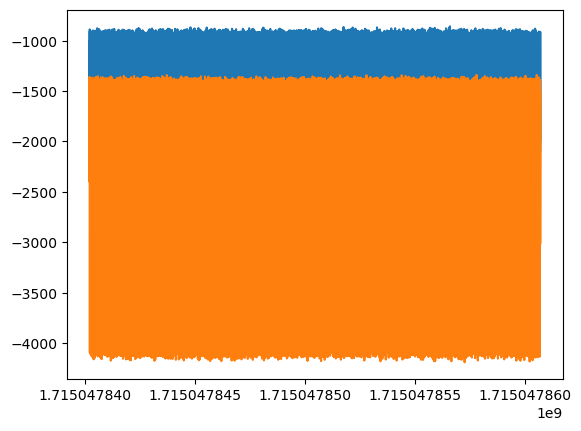

In [103]:
plt.plot(testing_chunk_channel_time_100['t'], testing_chunk_channel_time_100[['i','q']])

In [49]:
test_2 = read_chunk_data_2('ts_toneinit_fcenter_4250.0_20240506174818_t_20240506191017.hd5')

In [58]:
len(test_2)

1002

In [43]:
chunk_test = read_chunk_data('ts_toneinit_fcenter_4250.0_20240506174818_t_20240506191017.hd5')

In [45]:
chunk_test.shape

(293874576, 3)

In [38]:
len(chunk_test)

293874576

In [42]:
chunk_test.loc[0]

,t,i,q
channel,,,
0,1.715048e+09,587,-961
0,1.715048e+09,535,-953
0,1.715048e+09,515,-949
0,1.715048e+09,487,-933
0,1.715048e+09,504,-910
...,...,...,...
0,1.715048e+09,574,-947
0,1.715048e+09,582,-963
0,1.715048e+09,537,-955


In [41]:
chunk_test.index

Index([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       ...
       1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001],
      dtype='int64', name='channel', length=293874576)

In [33]:
chunk_test.index

Index([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       ...
       1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001],
      dtype='int64', name='channel', length=293874576)

In [13]:

t, adc_i, adc_q = dmd.read_data('ts_toneinit_fcenter_4250.0_20240506174818_t_20240506191017.hd5', 
          channels='all')

# first doing with pandas dataframe: 

# iterate through all times and create dataframe
chan_list = []
for channel in range(len(adc_i)):
    freq_channels_frame = pd.DataFrame({'t': t, 
                               'i': adc_i[channel], 
                               'q':adc_q[channel]
                               })
    freq_channels_frame['channel'] = channel 
    chan_list.append(freq_channels_frame)

    # combining them into single matrix: 
channels_chunked = pd.concat(chan_list)

# set index 
channels_chunked.set_index(['channel', 't'], inplace=True)


In [10]:
def read_data_chunked(filename, single_channel, time = 'all', t_start = [], t_stop = []):
    t, adc_i, adc_q = dmd.read_data(filename, 
          channels='all')
    # iterate through all times and create dataframe
    chan_list = []
    for channel in range(len(adc_i)):
        freq_channels_frame = pd.DataFrame({'t': t, 
                                'i': adc_i[channel], 
                                'q':adc_q[channel]
                                })
        freq_channels_frame['channel'] = channel 
        chan_list.append(freq_channels_frame)

    # combining them into single matrix: 
    channels_chunked = pd.concat(chan_list)

    # set index 
    channels_chunked.set_index(['channel', 't'], inplace=True)
    
    # chunking operations
    if time == 'all': # for all time, one channel
        chunk = channels_chunked.loc[single_channel]
    elif time == 'some': # for specific time range, one channel 
        chunk = channels_chunked.loc[single_channel].loc[t_start:t_stop]

    return chunk
    

In [11]:
test = read_data_chunked(filename = 'ts_toneinit_fcenter_4250.0_20240506174818_t_20240506191017.hd5', 
                         single_channel = 1000, time='all')

In [20]:
test

(0, 1715047821.7724793)

In [17]:
plt.plot(test['t'], test['i'])

TypeError: tuple indices must be integers or slices, not str